# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Apple/train",
    label_mode="categorical",
    class_names=['Apple Black rot', 'Apple Scab Leaf', 'Apple leaf Healthy', 'Apple rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Apple/valid",
    label_mode="categorical",
    class_names=['Apple Black rot', 'Apple Scab Leaf', 'Apple leaf Healthy', 'Apple rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 8014 files belonging to 4 classes.
==========================Validation Data====================
Found 1943 files belonging to 4 classes.


In [5]:
# All images will be rescaled by 1./256. and Augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Apple/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Apple/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 8014 images belonging to 4 classes.
Found 1943 images belonging to 4 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Fri May 26 18:18:12 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.03                 Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P0               29W /  N/A|   4501MiB /  6144MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling Augmentation

## DenseNet Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Apple_DenseNet_model1_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
DenseNet_model = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
DenseNet_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_max_pooling2d (Globa  (None, 1024)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 7,300,932
Trainable params: 7,217,284
Non-trainable params: 83,648
_________________________________________

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet_model_1 = DenseNet_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
401/401 [==============================] - ETA: 0s - loss: 0.3874 - accuracy: 0.9102
Epoch 1: val_accuracy improved from -inf to 0.76531, saving model to Apple_DenseNet_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Augmented\assets


401/401 [==============================] - 155s 346ms/step - loss: 0.3874 - accuracy: 0.9102 - val_loss: 0.9191 - val_accuracy: 0.7653 - lr: 0.0010
Epoch 2/100
401/401 [==============================] - ETA: 0s - loss: 0.1141 - accuracy: 0.9636
Epoch 2: val_accuracy improved from 0.76531 to 0.99485, saving model to Apple_DenseNet_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Augmented\assets


401/401 [==============================] - 132s 329ms/step - loss: 0.1141 - accuracy: 0.9636 - val_loss: 0.0124 - val_accuracy: 0.9949 - lr: 0.0010
Epoch 3/100
401/401 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.9719
Epoch 3: val_accuracy did not improve from 0.99485
401/401 [==============================] - 80s 200ms/step - loss: 0.0814 - accuracy: 0.9719 - val_loss: 0.3717 - val_accuracy: 0.8935 - lr: 0.0010
Epoch 4/100
401/401 [==============================] - ETA: 0s - loss: 0.0912 - accuracy: 0.9714
Epoch 4: val_accuracy did not improve from 0.99485
401/401 [==============================] - 75s 186ms/step - loss: 0.0912 - accuracy: 0.9714 - val_loss: 0.0268 - val_accuracy: 0.9928 - lr: 0.0010
Epoch 5/100
401/401 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.9767
Epoch 5: val_accuracy did not improve from 0.99485
401/401 [==============================] - 81s 203ms/step - loss: 0.0729 - accuracy: 0.9767 - val_loss: 0.1594 - v

INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Augmented\assets


401/401 [==============================] - 118s 293ms/step - loss: 0.0242 - accuracy: 0.9915 - val_loss: 0.0023 - val_accuracy: 0.9985 - lr: 1.0000e-04
Epoch 9/100
401/401 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9918
Epoch 9: val_accuracy did not improve from 0.99846
401/401 [==============================] - 77s 191ms/step - loss: 0.0190 - accuracy: 0.9918 - val_loss: 0.0053 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 10/100
401/401 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9940
Epoch 10: val_accuracy did not improve from 0.99846
401/401 [==============================] - 75s 187ms/step - loss: 0.0162 - accuracy: 0.9940 - val_loss: 0.0051 - val_accuracy: 0.9974 - lr: 1.0000e-04
Epoch 11/100
401/401 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9930
Epoch 11: val_accuracy improved from 0.99846 to 0.99897, saving model to Apple_DenseNet_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Augmented\assets


401/401 [==============================] - 113s 282ms/step - loss: 0.0186 - accuracy: 0.9930 - val_loss: 0.0019 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 12/100
401/401 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.9945
Epoch 12: val_accuracy did not improve from 0.99897
401/401 [==============================] - 77s 191ms/step - loss: 0.0157 - accuracy: 0.9945 - val_loss: 0.0096 - val_accuracy: 0.9964 - lr: 1.0000e-04
Epoch 13/100
401/401 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9939
Epoch 13: val_accuracy did not improve from 0.99897
401/401 [==============================] - 84s 208ms/step - loss: 0.0140 - accuracy: 0.9939 - val_loss: 0.0041 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 14/100
401/401 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9956
Epoch 14: val_accuracy did not improve from 0.99897
401/401 [==============================] - 86s 214ms/step - loss: 0.0103 - accuracy: 0.9956 - va

INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Augmented\assets


401/401 [==============================] - 127s 317ms/step - loss: 0.0100 - accuracy: 0.9964 - val_loss: 0.0014 - val_accuracy: 0.9995 - lr: 1.0000e-04
Epoch 16/100
401/401 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 0.9958
Epoch 16: val_accuracy improved from 0.99949 to 1.00000, saving model to Apple_DenseNet_model1_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model1_Based_Augmented\assets


401/401 [==============================] - 127s 317ms/step - loss: 0.0098 - accuracy: 0.9958 - val_loss: 6.5035e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 17/100
401/401 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9964
Epoch 17: val_accuracy did not improve from 1.00000
401/401 [==============================] - 86s 214ms/step - loss: 0.0108 - accuracy: 0.9964 - val_loss: 0.0025 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 18/100
401/401 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9946
Epoch 18: val_accuracy did not improve from 1.00000
401/401 [==============================] - 94s 233ms/step - loss: 0.0150 - accuracy: 0.9946 - val_loss: 0.0015 - val_accuracy: 0.9995 - lr: 1.0000e-04
Epoch 19/100
401/401 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9960
Epoch 19: val_accuracy did not improve from 1.00000
401/401 [==============================] - 88s 220ms/step - loss: 0.0106 - accuracy: 0.9960 

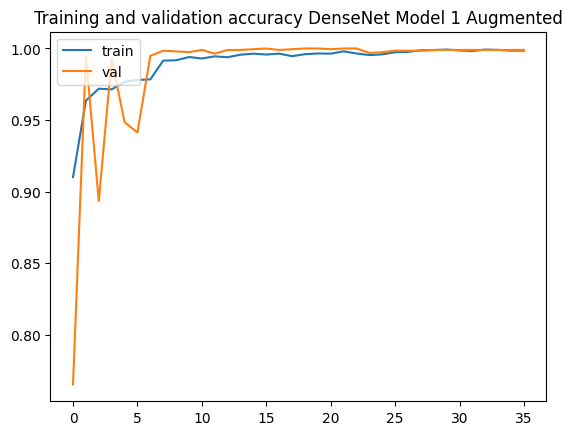

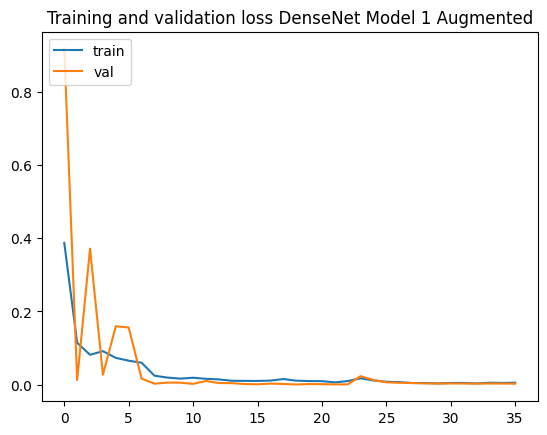

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet_model_1.history['accuracy' ]
val_acc  = history_DenseNet_model_1.history['val_accuracy' ]
loss     = history_DenseNet_model_1.history['loss' ]
val_loss = history_DenseNet_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DenseNet Model 1 Augmented')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DenseNet Model 1 Augmented')
plt.legend(['train', 'val'], loc='upper left')

## DenseNet Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Apple_DenseNet_model2_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
DenseNet_model_2 = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
DenseNet_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 7,300,932
Trainable params: 7,217,284
Non-trainable params: 83,648
_______________________________________

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet_model_2 = DenseNet_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
401/401 [==============================] - ETA: 0s - loss: 0.2431 - accuracy: 0.9193
Epoch 1: val_accuracy improved from -inf to 0.78744, saving model to Apple_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Augmented\assets


401/401 [==============================] - 163s 381ms/step - loss: 0.2431 - accuracy: 0.9193 - val_loss: 1.1290 - val_accuracy: 0.7874 - lr: 0.0010
Epoch 2/100
401/401 [==============================] - ETA: 0s - loss: 0.1251 - accuracy: 0.9597
Epoch 2: val_accuracy improved from 0.78744 to 0.81163, saving model to Apple_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Augmented\assets


401/401 [==============================] - 133s 331ms/step - loss: 0.1251 - accuracy: 0.9597 - val_loss: 1.0349 - val_accuracy: 0.8116 - lr: 0.0010
Epoch 3/100
401/401 [==============================] - ETA: 0s - loss: 0.0907 - accuracy: 0.9668
Epoch 3: val_accuracy improved from 0.81163 to 0.94699, saving model to Apple_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Augmented\assets


401/401 [==============================] - 127s 317ms/step - loss: 0.0907 - accuracy: 0.9668 - val_loss: 0.1397 - val_accuracy: 0.9470 - lr: 0.0010
Epoch 4/100
401/401 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9730
Epoch 4: val_accuracy improved from 0.94699 to 0.97015, saving model to Apple_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Augmented\assets


401/401 [==============================] - 128s 319ms/step - loss: 0.0844 - accuracy: 0.9730 - val_loss: 0.0902 - val_accuracy: 0.9701 - lr: 0.0010
Epoch 5/100
401/401 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9804
Epoch 5: val_accuracy did not improve from 0.97015
401/401 [==============================] - 92s 230ms/step - loss: 0.0629 - accuracy: 0.9804 - val_loss: 0.2636 - val_accuracy: 0.9398 - lr: 0.0010
Epoch 6/100
401/401 [==============================] - ETA: 0s - loss: 0.0743 - accuracy: 0.9750
Epoch 6: val_accuracy improved from 0.97015 to 0.98713, saving model to Apple_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Augmented\assets


401/401 [==============================] - 131s 326ms/step - loss: 0.0743 - accuracy: 0.9750 - val_loss: 0.0306 - val_accuracy: 0.9871 - lr: 0.0010
Epoch 7/100
401/401 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.9792
Epoch 7: val_accuracy did not improve from 0.98713
401/401 [==============================] - 88s 220ms/step - loss: 0.0640 - accuracy: 0.9792 - val_loss: 0.0549 - val_accuracy: 0.9815 - lr: 0.0010
Epoch 8/100
401/401 [==============================] - ETA: 0s - loss: 0.0686 - accuracy: 0.9785
Epoch 8: val_accuracy did not improve from 0.98713
401/401 [==============================] - 92s 228ms/step - loss: 0.0686 - accuracy: 0.9785 - val_loss: 0.0878 - val_accuracy: 0.9696 - lr: 0.0010
Epoch 9/100
401/401 [==============================] - ETA: 0s - loss: 0.0545 - accuracy: 0.9815
Epoch 9: val_accuracy improved from 0.98713 to 0.99382, saving model to Apple_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Augmented\assets


401/401 [==============================] - 134s 335ms/step - loss: 0.0545 - accuracy: 0.9815 - val_loss: 0.0153 - val_accuracy: 0.9938 - lr: 0.0010
Epoch 10/100
401/401 [==============================] - ETA: 0s - loss: 0.0449 - accuracy: 0.9840
Epoch 10: val_accuracy did not improve from 0.99382
401/401 [==============================] - 90s 224ms/step - loss: 0.0449 - accuracy: 0.9840 - val_loss: 0.0194 - val_accuracy: 0.9923 - lr: 0.0010
Epoch 11/100
401/401 [==============================] - ETA: 0s - loss: 0.0655 - accuracy: 0.9803
Epoch 11: val_accuracy did not improve from 0.99382
401/401 [==============================] - 83s 207ms/step - loss: 0.0655 - accuracy: 0.9803 - val_loss: 0.0779 - val_accuracy: 0.9738 - lr: 0.0010
Epoch 12/100
401/401 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.9827
Epoch 12: val_accuracy improved from 0.99382 to 0.99640, saving model to Apple_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Augmented\assets


401/401 [==============================] - 123s 308ms/step - loss: 0.0467 - accuracy: 0.9827 - val_loss: 0.0145 - val_accuracy: 0.9964 - lr: 0.0010
Epoch 13/100
401/401 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.9850
Epoch 13: val_accuracy did not improve from 0.99640
401/401 [==============================] - 87s 216ms/step - loss: 0.0413 - accuracy: 0.9850 - val_loss: 0.0198 - val_accuracy: 0.9959 - lr: 0.0010
Epoch 14/100
401/401 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 0.9845
Epoch 14: val_accuracy did not improve from 0.99640
401/401 [==============================] - 88s 219ms/step - loss: 0.0465 - accuracy: 0.9845 - val_loss: 0.0315 - val_accuracy: 0.9902 - lr: 0.0010
Epoch 15/100
401/401 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9835
Epoch 15: val_accuracy did not improve from 0.99640
401/401 [==============================] - 84s 209ms/step - loss: 0.0472 - accuracy: 0.9835 - val_loss: 0.02

INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Augmented\assets


401/401 [==============================] - 123s 307ms/step - loss: 0.0227 - accuracy: 0.9926 - val_loss: 0.0014 - val_accuracy: 0.9995 - lr: 1.0000e-04
Epoch 19/100
401/401 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9933
Epoch 19: val_accuracy improved from 0.99949 to 1.00000, saving model to Apple_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DenseNet_model2_Based_Augmented\assets


401/401 [==============================] - 124s 310ms/step - loss: 0.0166 - accuracy: 0.9933 - val_loss: 6.7527e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 20/100
401/401 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9928
Epoch 20: val_accuracy did not improve from 1.00000
401/401 [==============================] - 88s 218ms/step - loss: 0.0181 - accuracy: 0.9928 - val_loss: 4.1285e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 21/100
401/401 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9954
Epoch 21: val_accuracy did not improve from 1.00000
401/401 [==============================] - 89s 221ms/step - loss: 0.0119 - accuracy: 0.9954 - val_loss: 2.5794e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 22/100
401/401 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9959
Epoch 22: val_accuracy did not improve from 1.00000
401/401 [==============================] - 89s 220ms/step - loss: 0.0112 - accuracy:

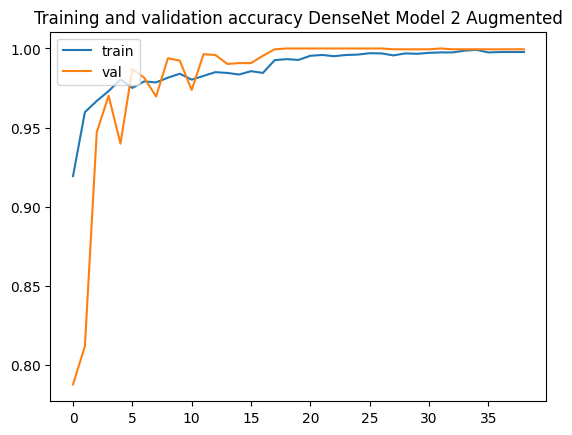

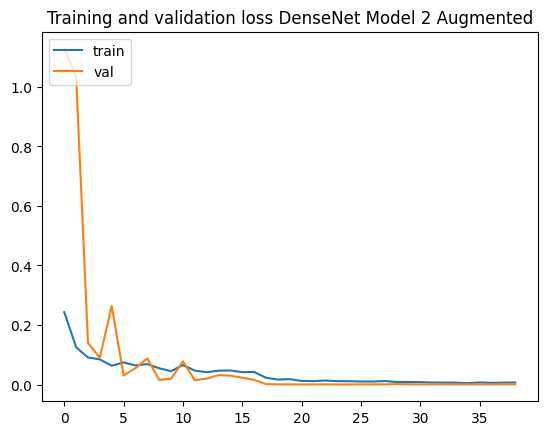

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet_model_2.history['accuracy' ]
val_acc  = history_DenseNet_model_2.history['val_accuracy' ]
loss     = history_DenseNet_model_2.history['loss' ]
val_loss = history_DenseNet_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DenseNet Model 2 Augmented')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DenseNet Model 2 Augmented')
plt.legend(['train', 'val'], loc='upper left')